# Imports

In [1]:
import os
import shutil
import zipfile
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [2]:
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.9.0+cpu
Using device: cpu


# Dataset

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
source_path = "/content/drive/MyDrive/Kaggle Competition/Dataset/nlp-getting-started.zip"
dest_path = "/content/data.zip"
data_path = "/content/nlp_data/"

shutil.copy(source_path, dest_path)
print("✅ File copied to Colab temporary storage.")

✅ File copied to Colab temporary storage.


In [5]:
with zipfile.ZipFile(dest_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)
print("✅ File extracted successfully.")

✅ File extracted successfully.


In [6]:
os.remove("/content/data.zip")
print("✅ ZIP file deleted successfully.")

✅ ZIP file deleted successfully.


In [7]:
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))

train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [8]:
pd.set_option('display.max_colwidth', None)
display(train_df.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


# Text Cleaning

In [9]:
import re

def clean_text(text):
    text = text.lower()

    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    return text

In [10]:
sample_tweet = "Fire in the building! Go to http://news.com/fire 123 <br>"
cleaned = clean_text(sample_tweet)

print(f"Original: {sample_tweet}")
print(f"Cleaned:  {cleaned}")

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# cleaned_list = []
# for txt in train_df['text']:
#     cleaned_list.append(clean_text(txt))
# train_df['clean_text'] = cleaned_list

display(train_df[['text', 'clean_text']].head())

Original: Fire in the building! Go to http://news.com/fire 123 <br>
Cleaned:  fire in the building go to   


,text,clean_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,our deeds are the reason of this earthquake may allah forgive us all
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California",people receive wildfires evacuation orders in california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,just got sent this photo from ruby alaska as smoke from wildfires pours into a school


# Preprocessing

In [11]:
from collections import Counter


train_df['tokens'] = train_df['clean_text'].apply(lambda x: x.split())
test_df['tokens'] = test_df['clean_text'].apply(lambda x: x.split())

all_words = []
for tokens in train_df['tokens']:
    all_words.extend(tokens)

word_counts = Counter(all_words)
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)

vocab_to_int = {word: i+2 for i, word in enumerate(sorted_words)}

vocab_to_int['<PAD>'] = 0  # Padding
vocab_to_int['<UNK>'] = 1  # Unknown

print(f"Number of all vocab: {len(vocab_to_int)}")
print(f"5 most frequent words: {sorted_words[:5]}")

Number of all vocab: 17242
5 most frequent words: ['the', 'a', 'in', 'to', 'of']


In [12]:
def tokens_to_ids(tokens, vocab):
    return [vocab.get(t, vocab['<UNK>']) for t in tokens]


train_df['indices'] = train_df['tokens'].apply(lambda x: tokens_to_ids(x, vocab_to_int))
test_df['indices'] = test_df['tokens'].apply(lambda x: tokens_to_ids(x, vocab_to_int))

display(train_df[['clean_text', 'indices']].head())

,clean_text,indices
0,our deeds are the reason of this earthquake may allah forgive us all,"[110, 4384, 22, 2, 820, 6, 19, 237, 124, 1539, 4385, 67, 39]"
1,forest fire near la ronge sask canada,"[178, 43, 216, 651, 6527, 6528, 1330]"
2,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,"[39, 1663, 1540, 5, 2046, 4, 652, 22, 121, 6529, 18, 1664, 41, 411, 238, 54, 2046, 4, 652, 1331, 22, 1054]"
3,people receive wildfires evacuation orders in california,"[57, 4386, 1332, 238, 1331, 4, 87]"
4,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,"[29, 94, 1158, 19, 318, 20, 6530, 2047, 26, 252, 20, 1332, 6531, 66, 3, 175]"


Max Length: 31
Mean Length: 13.78
Min Length: 1


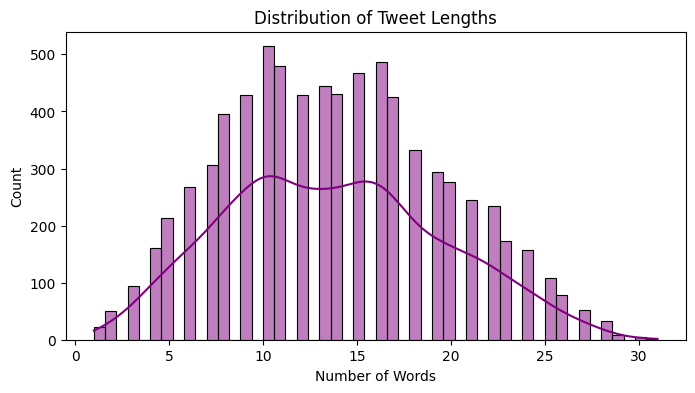

In [13]:
train_df['len'] = train_df['indices'].apply(len)

print(f"Max Length: {train_df['len'].max()}")
print(f"Mean Length: {train_df['len'].mean():.2f}")
print(f"Min Length: {train_df['len'].min()}")

plt.figure(figsize=(8, 4))
sns.histplot(train_df['len'], bins=50, kde=True, color='purple')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of Words')
plt.show()

In [14]:
MAX_LEN = 50

def pad_features(reviews_ints, seq_length):
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    for i, row in enumerate(reviews_ints):
        if len(row) > seq_length:
            features[i, :] = np.array(row)[:seq_length]
        else:
            features[i, :len(row)] = np.array(row)

    return features


train_features = pad_features(train_df['indices'], MAX_LEN)
test_features = pad_features(test_df['indices'], MAX_LEN)

train_features.shape, test_features.shape

((7613, 50), (3263, 50))

In [15]:
print(train_features[0])

[ 110 4384   22    2  820    6   19  237  124 1539 4385   67   39    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


# PyTorch

In [16]:
from torch.utils.data import TensorDataset, DataLoader, random_split


X_train_full = torch.tensor(train_features, dtype=torch.long)
X_test = torch.tensor(test_features, dtype=torch.long)

y_train_full = torch.tensor(train_df['target'].values, dtype=torch.float32)

print(f"X_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")

full_train_dataset = TensorDataset(X_train_full, y_train_full)
test_dataset = TensorDataset(X_test)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_set, val_set = random_split(full_train_dataset, [train_size, val_size])

print(f"Training Set: {len(train_set)}")
print(f"Validation Set: {len(val_set)}")

BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

sample_x, sample_y = next(iter(train_loader))
print("\nSample Batch Shapes:")
print(f"Input (Words): {sample_x.shape}")
print(f"Target (Label): {sample_y.shape}")

X_train shape: torch.Size([7613, 50])
y_train shape: torch.Size([7613])
Training Set: 6090
Validation Set: 1523

Sample Batch Shapes:
Input (Words): torch.Size([32, 50])
Target (Label): torch.Size([32])


# Model

In [29]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)

        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        embeds = self.embedding(x)

        lstm_out, _ = self.lstm(embeds)

        out, _ = torch.max(lstm_out, dim=1)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.sigmoid(out)

        return out

vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 64
hidden_dim = 256
n_layers = 2

model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)
print(model)

SentimentLSTM(
  (embedding): Embedding(17243, 64, padding_idx=0)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# Train

In [30]:
lr = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 10
clip = 5

valid_loss_min = np.inf

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):

    model.train()

    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        model.zero_grad()

        output = model(inputs)

        loss = criterion(output.squeeze(), labels)

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        pred = torch.round(output.squeeze())
        correct_train += (pred == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = train_loss / total_train
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)


    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            output = model(inputs)
            loss = criterion(output.squeeze(), labels)

            val_loss += loss.item() * inputs.size(0)

            pred = torch.round(output.squeeze())
            correct_val += (pred == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = val_loss / total_val
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")

    if epoch_val_loss <= valid_loss_min:
        print(f"\t✅ Validation loss decreased ({valid_loss_min:.4f} --> {epoch_val_loss:.4f}). Saving model...")
        torch.save(model.state_dict(), 'best_model.pth')
        valid_loss_min = epoch_val_loss

Epoch 1/10 | Train Loss: 0.6181 | Acc: 66.40% | Val Loss: 0.5504 | Val Acc: 72.09%
	✅ Validation loss decreased (inf --> 0.5504). Saving model...
Epoch 2/10 | Train Loss: 0.5147 | Acc: 75.58% | Val Loss: 0.5560 | Val Acc: 73.21%
Epoch 3/10 | Train Loss: 0.4368 | Acc: 80.74% | Val Loss: 0.5113 | Val Acc: 77.15%
	✅ Validation loss decreased (0.5504 --> 0.5113). Saving model...
Epoch 4/10 | Train Loss: 0.3629 | Acc: 85.06% | Val Loss: 0.5079 | Val Acc: 78.40%
	✅ Validation loss decreased (0.5113 --> 0.5079). Saving model...
Epoch 5/10 | Train Loss: 0.2851 | Acc: 88.83% | Val Loss: 0.5630 | Val Acc: 77.15%
Epoch 6/10 | Train Loss: 0.2272 | Acc: 91.69% | Val Loss: 0.6707 | Val Acc: 74.72%
Epoch 7/10 | Train Loss: 0.1676 | Acc: 94.07% | Val Loss: 0.7175 | Val Acc: 77.02%
Epoch 8/10 | Train Loss: 0.1320 | Acc: 95.09% | Val Loss: 0.7545 | Val Acc: 74.85%
Epoch 9/10 | Train Loss: 0.1004 | Acc: 96.35% | Val Loss: 0.8467 | Val Acc: 76.56%
Epoch 10/10 | Train Loss: 0.0894 | Acc: 96.70% | Val Loss:

# Visualization

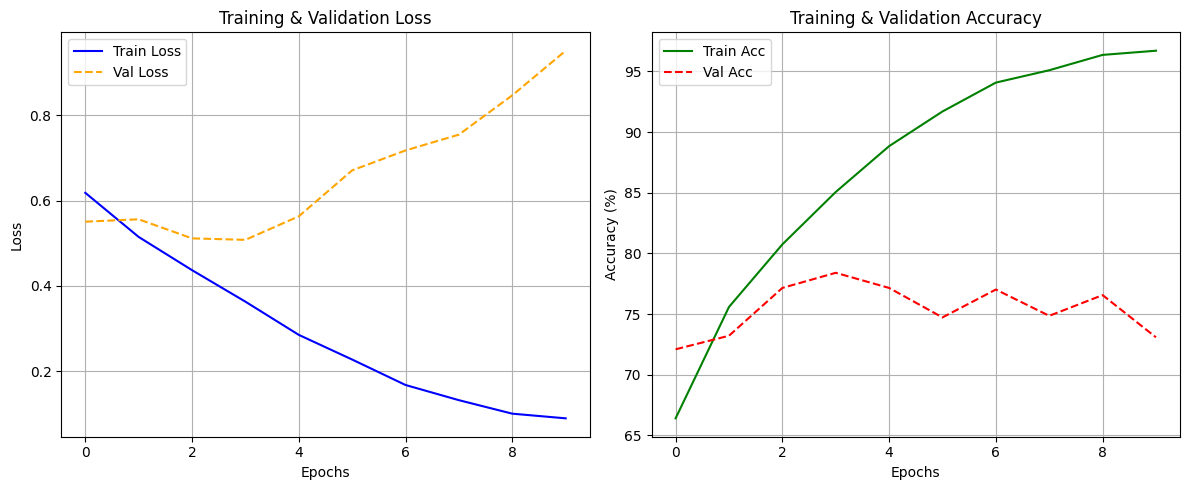

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange', linestyle='--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', color='green')
plt.plot(val_accs, label='Val Acc', color='red', linestyle='--')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Test Submission

In [34]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

predictions = []

with torch.no_grad():
    for batch in test_loader:

        inputs = batch[0]
        inputs = inputs.to(device)

        output = model(inputs)

        pred = torch.round(output.squeeze())

        predictions.extend(pred.cpu().numpy().astype(int))

print(f"Number of predictions: {len(predictions)}")
print(f"Number of rows in test file: {len(test_df)}")

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions
})

display(submission.head())
submission.to_csv('submission.csv', index=False)

Number of predictions: 3263
Number of rows in test file: 3263


,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
